# Amazon Review Sentiment Analysis

In this project, we aim to augment the current Amazon review system by proposing a novel approach based solely on using Natural Language Processing models to intepret and classify text-based reviews, removing the need for arbitrary assignment of numeric ratings by consumers. By limiting product review data solely to direct consumer sentiments, Amazon may be able to improve the utility of their review system, as well as the accuracy of their recommendation algorithms.

### Getting Started
To get started, we can import all relevant modules that will be used in this project.

In [0]:
from textblob import TextBlob
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml import *
from pyspark.ml.classification import *
from pyspark.ml.feature import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import *
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import * 
from pyspark.sql.functions import regexp_replace, trim, col, lower
from sklearn.metrics import classification_report
from time import time
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, string
from sklearn.metrics import confusion_matrix

Next, we'll create a SparkSession object

In [0]:
spark = SparkSession\
    .builder\
    .getOrCreate()

We can now build the schema with which to read in our data. The schemas are identical between both data files used in this project.

In [0]:
schema = StructType([
    StructField("id", StringType(), True),
    StructField("dateAdded", StringType(), True),
    StructField("dateUpdated", StringType(), True),
    StructField("name", StringType(), True),
    StructField("asins", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("categories", StringType(), True),
    StructField("primaryCategories", StringType(), True),
    StructField("imageURLs", StringType(), True),
    StructField("keys", StringType(), True),
    StructField("manufacturer", StringType(), True),
    StructField("manufacturerNumber", StringType(), True),
    StructField("reviews.date", StringType(), True),
    StructField("reviews.dateAdded", StringType(), True),
    StructField("reviews.dateSeen", StringType(), True),
    StructField("reviews.doRecommend", StringType(), True),
    StructField("reviews.id", StringType(), True),
    StructField("reviews.numHelpful", StringType(), True),
    StructField("reviews.rating", IntegerType(), True),
    StructField("reviews.sourceURLs", StringType(), True),
    StructField("reviews.text", StringType(), True),
    StructField("reviews.title", StringType(), True),
    StructField("reviews.username", StringType(), True),
    StructField("sourceURLs", StringType(), True)])

Using the above schema, we can read in and combine our data files.

In [0]:
raw_data1 = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ",")\
    .schema(schema)\
    .csv("/FileStore/tables/rawdata1/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")

raw_data2 = spark.read.format("csv")\
    .option("header", "true")\
    .option("delimiter", ",")\
    .schema(schema)\
    .csv("/FileStore/tables/rawdata2/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv")

raw_data = raw_data1.union(raw_data2) #concatentating the second dataset to the first

for name in raw_data.schema.names:
      raw_data = raw_data.withColumnRenamed(name, name.replace('.', '_')) #cleaning up column names

In [0]:
raw_data.cache()

Out[68]: DataFrame[id: string, dateAdded: string, dateUpdated: string, name: string, asins: string, brand: string, categories: string, primaryCategories: string, imageURLs: string, keys: string, manufacturer: string, manufacturerNumber: string, reviews_date: string, reviews_dateAdded: string, reviews_dateSeen: string, reviews_doRecommend: string, reviews_id: string, reviews_numHelpful: string, reviews_rating: int, reviews_sourceURLs: string, reviews_text: string, reviews_title: string, reviews_username: string, sourceURLs: string]

### Sentiment Analysis & Text Cleaning
In an initial step towards creating Natural Language Processing with our text data, we will clean and refine the text responses, then use binary labels to classify positive and negative reviews based on a pretrained sentiment analysis module.

In [0]:
#make all text lower case
raw_data = raw_data.withColumn('reviews_text',lower(col('reviews_text')))
#remove punctuation
raw_data = raw_data.withColumn('reviews_text', regexp_replace('reviews_text', "\p{Punct}", ""))

In [0]:
# features

tokenizer = RegexTokenizer(inputCol="reviews_text", outputCol="token").setPattern("\\W")
remover = StopWordsRemover(inputCol="token", outputCol="stopwordsremoved")
hashtf = HashingTF(inputCol="stopwordsremoved", outputCol='hashingTF')
idf = IDF(inputCol='hashingTF', outputCol="IDF")

# label
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "StringIndexer")

# pipeline 

pipeline = Pipeline(stages=[tokenizer, remover, hashtf, idf])

review = pipeline.fit(raw_data).transform(raw_data)

In [0]:
def textblob_udf(text):
    result = TextBlob(text).sentiment[0] #use the polarity to decide user's opinion
    if result >= 0.0:
        return 1.0
    else:
        return 0.0 
    
sentiment = udf(textblob_udf) #register udf

In [0]:
# create label column with the polarity values
reviews = raw_data.withColumn("label", sentiment(raw_data['reviews_text']))\
    .select('name','reviews_text','reviews_rating','label')

In [0]:
# convert the label data from StringType to IntegerType
reviews = reviews\
    .withColumn('label', reviews['label'].cast(IntegerType()))

In [0]:
# print schema and cache the dataframe
reviews.printSchema
reviews.cache()

Out[72]: DataFrame[name: string, reviews_text: string, reviews_rating: int, label: int]

In [0]:
# check for null values
reviews.filter('label is null').show()

### Data Exploration & Cleaning
To prepare our data for model training, it will be important to first clean and refine it, as well as explore any notable trends among data points.

In [0]:
reviews.select('reviews_rating').describe().show()

+-------+------------------+
summary| reviews_rating|
+-------+------------------+
 count| 32283|
 mean| 4.501037697859554|
 stddev|1.1602410620788028|
 min| 0|
 max| 97|
+-------+------------------+

In [0]:
# based on the above output, review sentiments appear relatively high. it is not uncommon to see consumers only offering reviews if they had a notably positive or negative experience with a product, or arbitrarily assigning polarized ratings (e.g 0 or 5) to products, which are issues we hope to address through removing the necessity of providing a numeric rating score. 

reviews.select('reviews_rating')\
    .groupBy('reviews_rating')\
    .count()\
    .orderBy('reviews_rating', ascending=True).show()

+--------------+-----+
reviews_rating|count|
+--------------+-----+
 null| 1049|
 0| 199|
 1| 1025|
 2| 664|
 3| 1366|
 4| 6498|
 5|22522|
 6| 1|
 8| 1|
 9| 1|
 12| 1|
 13| 1|
 16| 1|
 44| 1|
 49| 1|
 97| 1|
+--------------+-----+

In [0]:
# based on the above output, it's clear we'll need to drop some flawed data points - any ratings that are null or not between 1 and 5. 

values_list = [0, 1, 2, 3, 4, 5]
reviews = reviews.filter(reviews.reviews_rating.isin(values_list))

reviews.select('reviews_rating')\
    .groupBy('reviews_rating')\
    .count()\
    .orderBy('reviews_rating', ascending=True).show()

+--------------+-----+
reviews_rating|count|
+--------------+-----+
 0| 199|
 1| 1025|
 2| 664|
 3| 1366|
 4| 6498|
 5|22522|
+--------------+-----+

In [0]:
reviews.select('label')\
    .groupBy('label')\
    .count()\
    .orderBy('label', ascending=True).show()

+-----+-----+
label|count|
+-----+-----+
 0| 2307|
 1|29967|
+-----+-----+

In [0]:
# viewing matched versus mismatched review_ratings to label

reviews.select('reviews_rating','label')\
    .groupBy('reviews_rating','label')\
    .count()\
    .orderBy('reviews_rating', ascending=True)\
    .show()

+--------------+-----+-----+
reviews_rating|label|count|
+--------------+-----+-----+
 0| 1| 199|
 1| 1| 512|
 1| 0| 513|
 2| 1| 431|
 2| 0| 233|
 3| 0| 270|
 3| 1| 1096|
 4| 0| 375|
 4| 1| 6123|
 5| 0| 916|
 5| 1|21606|
+--------------+-----+-----+

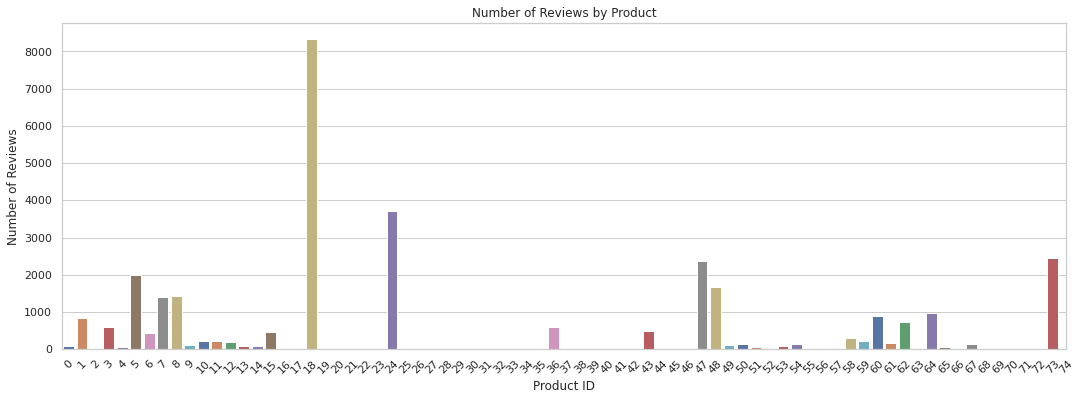

In [0]:
# as mentioned above, reviews are frequently submitted due to strong positive or negative experiences with a product. examining whether any specific products received a disproportionate share of reviews may offer additional insight into our data

# we'll first convert our Spark DataFrame to a Pandas DataFrame so that we can generate visuals using Seaborn.

reviews_pandas = reviews.toPandas()

# now, we can plot a countplot of number of reviews per product 

sns.set(rc={'figure.figsize':(18,6)})
sns.set_style('whitegrid')
ax = sns.countplot(x=reviews_pandas['name'], palette = 'deep')
locs, labels = plt.xticks(ticks = range(75), labels = range(75)) # due to the length of product names, we will be referencing them by unique numerical IDs
plt.setp(labels, rotation=45)
plt.title('Number of Reviews by Product')
plt.xlabel('Product ID')
plt.ylabel('Number of Reviews')
plt.show()

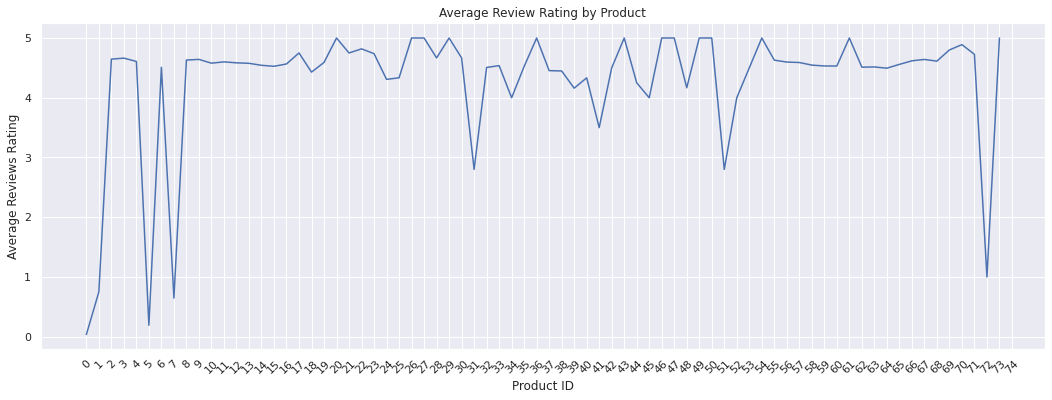

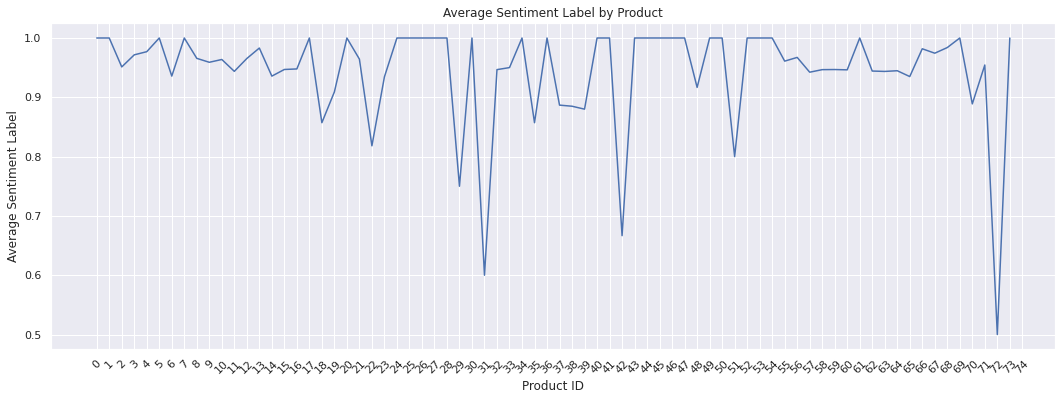

In [0]:
# clearly, Product 18 (Amazon AAA batteries) receive substantially more reviews than other products included in this dataset! it may be interesting to compare the above chart to a similar visualization displaying the average rating score given to each product, as well as the average sentiment label score for each product. 

sns.set(rc={'figure.figsize':(18,6)})

ratings_means = reviews_pandas.groupby('name')['reviews_rating'].agg('mean').reset_index() # calculating mean rating values
labels_means = reviews_pandas.groupby('name')['label'].agg('mean').reset_index() # calculating mean label values

sns.lineplot(x='name', y='reviews_rating', data=ratings_means, palette = 'deep')
locs, labels = plt.xticks(ticks = range(75), labels = range(75))
plt.setp(labels, rotation=45)
plt.title('Average Review Rating by Product')
plt.xlabel('Product ID')
plt.ylabel('Average Reviews Rating')
plt.show()

sns.lineplot(x='name', y='label', data=labels_means, palette = 'deep')
locs, labels = plt.xticks(ticks = range(75), labels = range(75))
plt.setp(labels, rotation=45)
plt.title('Average Sentiment Label by Product')
plt.xlabel('Product ID')
plt.ylabel('Average Sentiment Label')
plt.show()

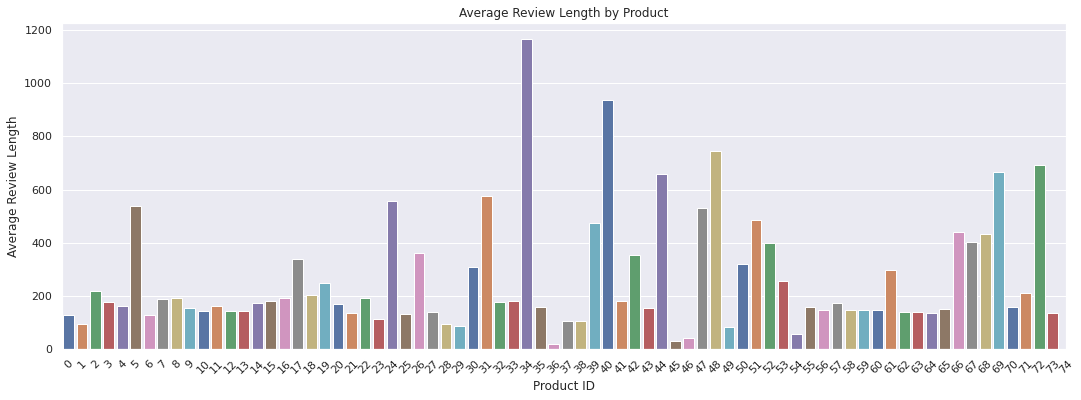

In [0]:
# importantly, the above graphs show that there are a multitude of instances where the numeric rating assigned to a product does not appear aligned to the sentiment label attached to the associated text response. this underscores the value of a purely text-based review model which would eliminate this confusing discrepancy.

# given our interest in using solely text-based response data to generate product ratings, an important consideration will also be whether length of review is related to numeric rating. 

sns.set(rc={'figure.figsize':(18,6)})

reviews_pandas['Review Length'] = reviews_pandas['reviews_text'].str.len() # create text length column
reviewlength_means = reviews_pandas.groupby('name')['Review Length'].agg('mean').reset_index() # calculating mean review lengths

sns.barplot(x='name', y='Review Length', data=reviewlength_means, palette = 'deep')
locs, labels = plt.xticks(ticks = range(75), labels = range(75))
plt.setp(labels, rotation=45)
plt.title('Average Review Length by Product')
plt.xlabel('Product ID')
plt.ylabel('Average Review Length')
plt.show()


In [0]:
# we can also directly calculate a Pearson's r correlation coefficient to evaluate whether length of review is significantly related to review rating. as is shown in the output below, length of review appears weakly inversely related to review rating. 

correlation = reviews_pandas['reviews_rating'].corr(reviews_pandas['Review Length']) # determine correlation coefficient
correlation

Out[82]: -0.15349450957064428

### Preparing Data & Building NLP Pipeline
Following data cleaning and exploration, we're now ready to move into building an NLP Pipeline. We will use both Logistic Regression and Random Forest Models. We'll first split our data into training and test sets.

In [0]:
# splitting the data into train and test sets
train_set, test_set = reviews.randomSplit([0.7, 0.3], seed=5)

In [0]:
# features
tokenizer = RegexTokenizer(inputCol="reviews_text", outputCol="token").setPattern("\\W")
remover = StopWordsRemover(inputCol="token", outputCol="stopwordsremoved")
hashtf = HashingTF(inputCol="stopwordsremoved", outputCol='hashingTF')
idf = IDF(inputCol='hashingTF', outputCol="IDF")

# label
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "StringIndexer")

# pipeline
pipeline = Pipeline(stages=[tokenizer, remover, hashtf, idf, label_stringIdx])
model = pipeline.fit(train_set)
train_df = model.transform(train_set)
test_df = model.transform(test_set)

### Logistic Regression Model

In [0]:
# train the logistic regression model
log_reg = LogisticRegression(labelCol="label", featuresCol="hashingTF", 
                        maxIter=50, regParam=0.3)
lr_model = log_reg.fit(train_df)

In [0]:
# run the logistic regression model
lr_predict = lr_model.transform(test_df)
lr_final = lr_predict.select("name", "reviews_rating", "prediction", "label")
lr_final\
    .groupBy('reviews_rating','prediction', 'label')\
    .count()\
    .distinct()\
    .orderBy('reviews_rating', ascending=True)\
    .show()

+--------------+----------+-----+-----+
reviews_rating|prediction|label|count|
+--------------+----------+-----+-----+
 0| 1.0| 1| 17|
 1| 0.0| 0| 36|
 1| 1.0| 1| 37|
 1| 1.0| 0| 12|
 1| 0.0| 1| 4|
 2| 1.0| 0| 9|
 2| 0.0| 0| 14|
 2| 1.0| 1| 40|
 3| 1.0| 0| 8|
 3| 0.0| 1| 2|
 3| 0.0| 0| 12|
 3| 1.0| 1| 93|
 4| 0.0| 0| 23|
 4| 1.0| 0| 17|
 4| 1.0| 1| 617|
 4| 0.0| 1| 2|
 5| 1.0| 1| 2108|
 5| 1.0| 0| 39|
 5| 0.0| 1| 11|
 5| 0.0| 0| 34|
+--------------+----------+-----+-----+

In [0]:
lr_correct = lr_final\
    .filter(lr_final.prediction == lr_final.label)\
    .count()

lr_total = lr_final.count()

print("Correct Prediction:", lr_correct, ", Total:", lr_total, 
      ", Accuracy Rate:", lr_correct/lr_total)

Correct Prediction: 3031 , Total: 3135 , Accuracy Rate: 0.9668261562998405

In [0]:
#confusion matrix

pddf = lr_final.toPandas()

y_pred = pddf['prediction']
y_act = pddf['label']

cf_matrix = confusion_matrix(y_act, y_pred)


group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Visualizing the Logistic Regression Model
To contextualize the results of testing our Logistic Regression Model, we can build some visuals to represent interesting or notable data trends.

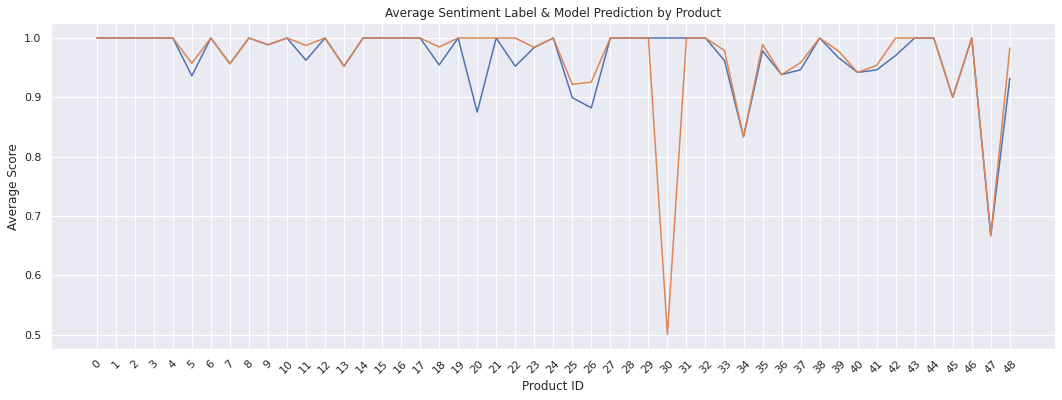

In [0]:
# we can visualize our model's average prediction for each product relative to their actual average sentiment rating to get a sense of its accuracy. to start, we'll need to create a Pandas DataFrame to work with

logreg_pandas = lr_final.toPandas() # converting to Pandas DataFrame
PandasDF_raw = raw_data.select("reviews_text").toPandas()
logreg_pandas['RawText'] = PandasDF_raw['reviews_text'].astype(str) # adding raw review text column to DataFrame

sentiment_means = logreg_pandas.groupby('name')['label'].agg('mean').reset_index() # calculating average sentiment rating by product
model_means = logreg_pandas.groupby('name')['prediction'].agg('mean').reset_index() # calculating average model prediction by product

plt.plot(sentiment_means['name'], sentiment_means['label'], label = "Average Sentiment Label")
plt.plot(model_means['name'], model_means['prediction'], label = "Average Model Prediction")
locs, labels = plt.xticks(ticks = range(49), labels = range(49))
plt.setp(labels, rotation=45)
plt.title("Average Sentiment Label & Model Prediction by Product")
plt.xlabel("Product ID")
plt.ylabel("Average Score")
plt.show()

In [0]:
# we can divide reviews into positive and negative sentiments to examine key word distribution across each, allowing us to identify specific words frequently cited in consumer reviews

Pos_Reviews = logreg_pandas[logreg_pandas['label'] == 1] #assigning reviews to positive and negative sentiment categories
Neg_Reviews = logreg_pandas[logreg_pandas['label'] == 0]

mostfrequent_pos = pd.Series(' '.join(Pos_Reviews['RawText']).lower().split()).value_counts()[:100]
mostfrequent_neg = pd.Series(' '.join(Neg_Reviews['RawText']).lower().split()).value_counts()[:100]
mostfrequent_pos_list = mostfrequent_pos.tolist() #converting to list for later filtering
mostfrequent_neg_list = mostfrequent_neg.tolist()

positive_df = pd.DataFrame([mostfrequent_pos]) #creating a positive reviews dataframe to examine
pos_df_transposed = positive_df.transpose()
pos_df_transposed.columns = ["Count"]
pos_df_transposed['Word'] = pos_df_transposed.index
pos_df_transposed[:25] #display top 25 most used words in positive reviews

Out[44]:

,Count,Word
the,3587,the
to,2840,to
and,2779,and
i,2334,i
it,2042,it
for,1882,for
a,1771,a
is,1611,is
my,1562,my
this,1262,this


In [0]:
# clearly, stop words make up the immense bulk of words within reviews, as would be expected. we will therefore remove these stopwords using two methods: first, by directly specifying the stop words we want to remove, and second, by removing any words that are within the top 100 most used words in both positive and negative reviews. 

stopwords = ["the", "to", "and", "i", "it", "for", "a", "is", "my", "this", "with", "of", "have", "on", "that", "in", "you", "was", "but", "can",
            "as", "so", "than", "am", "does", "we", "very", "not", "she", "it", "be", "all", "they", "it.", "has", "from", "just", "an", "it's",
            "get", "at", "are", "when", "he", "she", "or", "your"]
pos_df_transposed = pos_df_transposed[~pos_df_transposed['Word'].isin(stopwords) & ~pos_df_transposed['Word'].isin(mostfrequent_neg_list)]
pos_df_transposed

Out[45]:

,Count,Word
great,790,great
love,681,love
echo,511,echo
easy,434,easy
use,414,use
bought,411,bought
tablet,388,tablet
amazon,346,amazon
alexa,333,alexa
loves,309,loves


Out[46]:

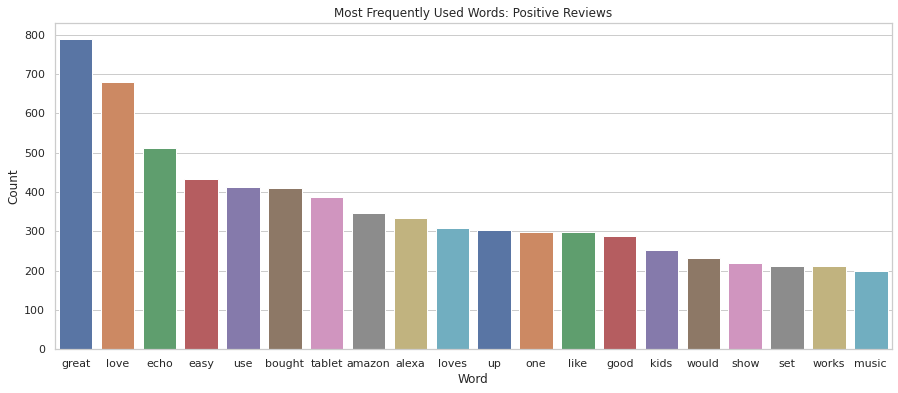

Text(0.5, 1.0, 'Most Frequently Used Words: Positive Reviews')

In [0]:
# finally, we can visually the top 20 most frequently used words in positive reviews

sns.set(rc={'figure.figsize':(15,6)})
sns.set_style("whitegrid")
sns.barplot(x='Word', y='Count', data=pos_df_transposed[:20], palette='deep')
plt.title("Most Frequently Used Words: Positive Reviews")

Out[47]:

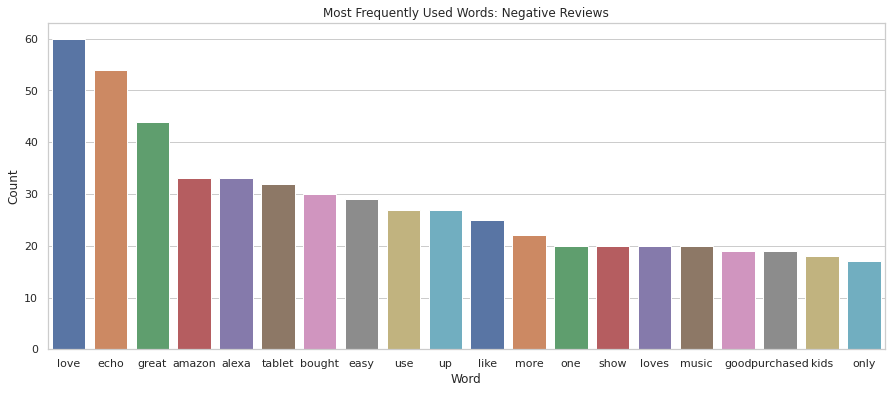

Text(0.5, 1.0, 'Most Frequently Used Words: Negative Reviews')

In [0]:
# we can repeat a similar process for negative reviews

negative_df = pd.DataFrame([mostfrequent_neg]) 
neg_df_transposed = negative_df.transpose()
neg_df_transposed.columns = ["Count"]
neg_df_transposed['Word'] = neg_df_transposed.index

neg_df_transposed = neg_df_transposed[~neg_df_transposed['Word'].isin(stopwords) & ~neg_df_transposed['Word'].isin(mostfrequent_pos_list)]

sns.barplot(x='Word', y='Count', data=neg_df_transposed[:20], palette='deep')
plt.title("Most Frequently Used Words: Negative Reviews")